# Evaluating ANCOR on anaphora with an interrogative word

In [1]:
import os
import sys
from lxml import etree
import pyconll
import pandas as pd
import seaborn as sns
import csv

# tei and xml prefixes
ns = {'tei': 'http://www.tei-c.org/ns/1.0',
      'xml': 'http://www.w3.org/XML/1998/namespace'}

In [2]:
int_words = ['qui', 'où', 'quoi', 'quand', 'comment', 'pourquoi',
             'quel', 'quelle', 'quelles', 'quels', 'combien', 'que',
             'lequel', 'lesquels', 'laquelle', 'lesquelles']

In [3]:
corpus_dir = "corpus"
fudia_dir = "fudia"
notmentioned_dir = "notmentioned"
notinchain_dir = "notinchain"
inchain_dir = "inchain"

In [4]:
# Utils
def get_fileid(filename:str) -> str:
    f = filename.split('/')[-1]
    return '.'.join(f.split('.')[:-1])

def attrib(tree, prefix:str, tag:str) -> str:
    """Returns the attribute of the root of tree of name prefix:tag,
    given the ns dictionary"""
    try:
        return tree.attrib['{'+ns[prefix]+'}'+tag]
    except KeyError:
        return ""
    
def boolify(s:str):
    return s == "YES"

def word_id(id:str):
    """Returns the integer section, utterance and word ids
    of a word id given as a string"""
    s = id.split('.')
    return (int(s[0].strip('s')), int(s[1].strip('u')), int(s[2].strip('w')))

def string_id(s:int, u:int, w:int):
    """Returns the string id of section s, utterance u and word w"""
    return "s"+str(s)+".u"+str(u)+".w"+str(w)

def ids_in_between(from_id:str, to_id:str):
    """Returns the list of str ids in between (largely) from_id and to_id
    We assume that both are in the same section and utterrance"""
    from_id = word_id(from_id)
    to_id = word_id(to_id)
    assert from_id[0] == to_id[0] and from_id[1] == to_id[1]
    return [string_id(to_id[0],to_id[1],i) for i in range(from_id[2], to_id[2]+1)]


In [5]:
# string format to display the text of an anaphora

def format_chain(chainid:str, loc_wordid2sentid:dict, loc_mentid2wordids:dict, loc_chainid2mentids:dict,
               loc_sentid2wordids:dict, loc_wordid2word:dict, context_radius=2, expand=False) -> str:
    ellipsis = False
    string = ""
    cur_ment_idx = -1 # Mentions are supposed to be sorted

    ment_sents = set([loc_wordid2sentid[loc_mentid2wordids[m][0]] for m in loc_chainid2mentids[chainid]])
    radius = context_radius // 2 if len(ment_sents) > 1 else context_radius # enlarging the outputted text
    for ment_sent in range(max(0,min(ment_sents) - radius), min(max(ment_sents) + 1 + (radius * 2),max(set(loc_sentid2wordids.keys())))):

        context = set(range(ment_sent - (radius * 2), ment_sent + 1 + radius))
        if context.intersection(set(ment_sents)) == set(): # Only displays sentences including a radius of the chain
            if not ellipsis: # ellipsis gloss
                ellipsis = True
                string += " [...]"

        else:
            appendum = ""
            ellipsis = False
            for wordid in loc_sentid2wordids[ment_sent]:
                appendum += " "
                if cur_ment_idx+1 < len(loc_chainid2mentids[chainid]) and \
                    wordid == loc_mentid2wordids[loc_chainid2mentids[chainid][cur_ment_idx+1]][0]:
                    cur_ment_idx += 1
                    appendum += "**["
                appendum += loc_wordid2word[wordid]
                if wordid == loc_mentid2wordids[loc_chainid2mentids[chainid][cur_ment_idx]][-1]:
                    appendum += "]**"
            if appendum.strip() != "":
                string += appendum + "."
                if expand:
                    string += "\n\t"
    
    return string[1:]


def chain_strings_aux(mentids:list, loc_wordid2sentid:dict, loc_mentid2wordids:dict, loc_chainid2mentids:dict,
               loc_sentid2wordids:dict, loc_wordid2word:dict, context_radius=2, expand=False) -> str:
    """Outputs the string chains a list of mentions belongs to. Or its own sentence if it belongs to no chain"""
    sel_chainids = []
    found_mentids = set()
     # collecting chains containing one of the input mention ids
    for chainid in loc_chainid2mentids.keys():
        for mentid in mentids:
            if mentid in loc_chainid2mentids[chainid]:
                sel_chainids.append(chainid)
                found_mentids.add(mentid)

    # formatting the chains
    output = ""
    for chainid in sel_chainids:
        output += " * " + chainid + ": " + str(loc_chainid2mentids[chainid]) + "\n"
        output += "\t" + format_chain(chainid, loc_wordid2sentid, loc_mentid2wordids, loc_chainid2mentids,
               loc_sentid2wordids, loc_wordid2word, context_radius, expand) + "\n"
    # also outputting mentions belonging to no chain
    for mentid in mentids: # 
        if mentid not in found_mentids:
            output += " * [" + mentid + "]\n"
            output += "\t" + format_chain("#", loc_wordid2sentid, loc_mentid2wordids, {'#':[mentid]},
               loc_sentid2wordids, loc_wordid2word, context_radius, expand) + "\n"
    
    return output

        

## Retrieving the anaphora data

In [6]:
# Main dictionaries
# key: fileid, value: a dict
fileid2corpus = {} # corpora: ESLO, OTG, UBS, ESLO_CO2
wordid2word = {}
wordid2sentid = {}
sentid2wordids = {}
mentid2wordids = {}
mentid2new = {} # value: whether the mention has NEW=Yes
chainid2mentids = {}
chainid2pro = {} # value: whether the chain includes a pronoun
chainid2coref = {} # value: whether the chain is a co-reference (i.e. not associative)

def chain_strings(mentids:list, fileid:str, context_radius=2, expand=False) -> str:
    "Formats a list of mention ids into a a string displaying the sentences containing the chain containing these mentions"
    "plus some sentences around"
    return chain_strings_aux(mentids, wordid2sentid[fileid], mentid2wordids[fileid], chainid2mentids[fileid],
               sentid2wordids[fileid], wordid2word[fileid], context_radius, expand)

def sentence_strings(wordids:list, fileid:str, context_radius=2, expand=False) -> str:
    "Formats a list of word ids into a a string displaying the sentences containing these word ids"
    "plus some sentences around"
    mentids = [str(i) for i in range(len(wordids))]
    return chain_strings_aux(mentids, wordid2sentid[fileid], {str(i):[w] for (i,w) in enumerate(wordids)}, {i:[i] for i in mentids},
               sentid2wordids[fileid], wordid2word[fileid], context_radius, expand)

def int_word_in_mention(mentid:str, fileid:str) -> str:
    """Given the interrogative word that belongs to the input interrogative mention.
    Returns the empty string is no interrogative word is detected"""
    words = [wordid2word[fileid][wordid] for wordid in mentid2wordids[fileid][mentid]]
    for word in words:
            if word in int_words:
                return word
    return ""



In [7]:
# Function charging the dictionaries for a given tei file
def get_annotations(filename:str):
    fileid = get_fileid(filename)
    try:
        tree = etree.parse(filename)
    except etree.ParseError as err:
        print("File:", filename, file=sys.stderr)
        print(err, file=sys.stderr)
        exit(1)
    root = tree.getroot()

    # Retrieving subtrees
    sent_trees = []
    for t in root[1][0].findall('tei:div', ns):
        if attrib(t, 'tei', 'type') == "section":
            sent_trees += t.findall('tei:u', ns)
    ment_trees = []
    for t in root[2].findall('tei:spanGrp', ns):
        ment_trees += t.findall('tei:span', ns)
    coref_trees = []
    for t in root[2].findall('tei:linkGrp', ns):
        coref_trees += t.findall('tei:link', ns)

    ### Formatting word ids, mentions and coreferences
    # Words and sentences
    words = []
    for s in sent_trees:
        words.append([])
        for w in s.findall('tei:w', ns):
            words[-1].append([attrib(w,'xml','id'), w.text])
        for pc in s.findall('tei:pc', ns):
            words[-1].append([attrib(pc,'xml','id'), pc.text])
        words[-1].sort(key=lambda w_i: word_id(w_i[0]))
    wordid2word[fileid] = {w[0]:w[1] for s in words for w in s}
    wordid2sentid[fileid] = {w[0]:i for i,s in enumerate(words) for w in s}
    sentid2wordids[fileid] = {i:[w[0] for w in s] for i,s in enumerate(words)}

    # Mentions
    mentions = []
    for m in ment_trees:
        target = attrib(m,'tei','target').replace('#','')
        if len(target) > 0: # Discontinuous mentions
            mentions.append([attrib(m,'xml','id')] + target.split(' '))
        else: # Continuous mentions
            target = ids_in_between(attrib(m,'tei','from').strip('#'), attrib(m,'tei','to').strip('#'))
            mentions.append([attrib(m,'xml','id')] + target)
    mentid2wordids[fileid] = {m[0]:m[1:] for m in mentions}
    for m in mentid2wordids[fileid].keys():
        mentid2wordids[fileid][m].sort(key=lambda id: word_id(id))

    # Mention novelty feature
    mentid2new[fileid] = {}
    mentid2pro = {}
    for t in root[2].findall('tei:div', ns):
        if attrib(t,'tei','type') == "unit-fs":
            for subt in t.findall('tei:fs', ns):
                m = '-'.join(attrib(subt, 'xml', 'id').split('-')[:-1])
                for f in subt.findall('tei:f', ns):
                    if attrib(f, 'tei', 'name') == "NEW":
                        mentid2new[fileid][m] = boolify(f[0].text)
                    if attrib(f, 'tei', 'name') == "type":
                        mentid2pro[m] = f[0].text == "PR"

    # Coreferences
    chains = [[attrib(c,'xml','id')] \
          + attrib(c,'tei','target').replace('#','').split(' ')
            for c in coref_trees]
    chainid2mentids[fileid] = {
        c[0]:[m for m in c[1:] if m in mentid2wordids[fileid].keys()] for c in chains}
    temp_corefs = list(chainid2mentids[fileid].keys())
    for c in temp_corefs:
        chainid2mentids[fileid][c].sort(key=lambda m: word_id(mentid2wordids[fileid][m][0]))


In [8]:
# Loading dictionaries by looping on the files
for corpus in os.listdir(corpus_dir):
    corp = '_'.join(corpus.split('_')[1:])
    for filename in os.listdir(corpus_dir + '/' + corpus):
        fileid = get_fileid(filename)
        fileid2corpus[fileid] = corp
        if filename[-4:] == ".tei":
            get_annotations(corpus_dir+'/'+corpus+'/'+filename)

print(list(chainid2mentids['021_C-6'].keys())[:10])

['r-COREFERENCE-jmuzerelle_1356881863910', 'r-COREFERENCE-jmuzerelle_1356881884190', 'r-COREFERENCE-jmuzerelle_1356881896529', 'r-COREFERENCE-jmuzerelle_1356881904704', 'r-COREFERENCE-jmuzerelle_1356881908978', 'r-COREFERENCE-jmuzerelle_1356881917153', 'r-COREFERENCE-jmuzerelle_1356881922940', 'r-COREFERENCE-jmuzerelle_1356881931926', 'r-COREFERENCE-jmuzerelle_1356881938618', 'r-COREFERENCE-jmuzerelle_1356882002516']


## Retrieving the syntax data

In [9]:
fileid2intwordids = {}

In [10]:
# Function collecting the word ids that are annotated with PronType="Int"
def get_syntax(filename:str):
    fileid = get_fileid(filename)
    fileid2intwordids[fileid] = []
    tree = pyconll.load_from_file(filename)

    # Extract tokens with PronType
    for sentence in tree:
        for token in sentence:
            # Getting word id
            if token.form != '__NOFORM__':
                if 'id' not in token.misc or len(token.misc['id']) != 1:
                    print(token.id, token.form)
                    raise ValueError
                else:
                    wordid = list(token.misc['id'])[0]
                # Adding to list if it's an interrogative word
                if 'PronType' in token.feats:
                    pt = list(token.feats['PronType'])
                    if len(pt) != 1:
                        raise ValueError
                    elif pt[0] == 'Int':
                        fileid2intwordids[fileid].append(wordid)
    

In [11]:
# Loading set of interrogative words by looping on the files
for corpus in os.listdir(fudia_dir):
    for filename in os.listdir(fudia_dir + '/' + corpus):
        if filename[-7:] == ".conllu":
            get_syntax(fudia_dir+'/'+corpus+'/'+filename)

print(fileid2intwordids['021_C-6'])

['s1.u0.w9', 's3.u10.w12', 's3.u19.w11', 's4.u0.w1', 's4.u15.w6', 's7.u3.w0', 's7.u3.w5', 's7.u5.w0', 's7.u9.w18', 's7.u15.w1', 's8.u7.w1', 's8.u17.w0', 's10.u0.w1', 's12.u22.w3', 's12.u34.w23', 's12.u46.w21', 's12.u51.w10']


In [12]:
# Number of interrogative words detected
print(sum([len(fileid2intwordids[fileid]) for fileid in fileid2intwordids.keys()]))

2581


## Assessing interrogative mentions

In [13]:
fileid2intmentids = {}
fileid2notmentioned = {}
fileid2intchainids = {}
fileid2notinchain = {} # list of interrogative mentions not in a chain (of length >= 2)
in_several_mentions = []

# Getting all interrogative mentions and interrogative words not in any mention
for fileid in fileid2corpus.keys():
    fileid2intmentids[fileid] = []
    fileid2notmentioned[fileid] = []
    for wordid in fileid2intwordids[fileid]:
        in_mention = False
        for mentid in mentid2wordids[fileid].keys():
            if wordid in mentid2wordids[fileid][mentid]:
                fileid2intmentids[fileid].append(mentid)
                # Safety check: are there interrogative words included in several mentions ?
                if in_mention:
                    in_several_mentions.append([fileid, wordid])
                in_mention = True
        if not in_mention:
            fileid2notmentioned[fileid].append(wordid)

# Getting all interrogative chains
for fileid in fileid2corpus.keys():
    fileid2intchainids[fileid] = []
    fileid2notinchain[fileid] = []
    for mentid in fileid2intmentids[fileid]:
        in_chain = False
        for chainid in chainid2mentids[fileid].keys():
            if mentid in chainid2mentids[fileid][chainid]:
                fileid2intchainids[fileid].append(chainid)
                in_chain = True
        if not in_chain:
            fileid2notinchain[fileid].append(mentid)

print(sentence_strings(fileid2intwordids['026_C-3'], '026_C-3'))
print(chain_strings(fileid2intmentids['021_C-6'], '021_C-6'))

 * 0: ['0']
	euh et lorsque vous votez pour un député madame **[qu']** est -ce que vous attendez de lui quand vous votez est -ce que. ça vous savez hein ça quand on vote pour un député on a vu d' ailleurs en général on les connaît on connaît quand même leurs façons d' agir on connaît on a lu toutes leurs déclarations hein ? alors on espère qu' ils agiront suivant vos propres idées par exemple sur ce que vous souhaitez voir enfin. oui et vous croyez que que v- euh vous votez pour euh le la personnalité ou est -ce pour le parti ou pour les idées qu' il représente ?. vous savez je ne fais pas de politique hein ? je ne fais pas de politique c'est-à-dire que euh on est quand même p- plus ou moins d' accord avec leur position malgré tout hein ? je crois qu' on voit ça surtout suivant son niveau suivant vous pensez pas ? je pense que ça c' est sûr ça se fait surtout par comme ça pour le niveau social pour euh.
 * 1: ['1']
	je pense qui correspond le mieux à à à ce qu' on peut espérer et tu le

In [14]:
print("Number of interrogative words not in a mention:", sum([len(fileid2notmentioned[fileid]) for fileid in fileid2corpus.keys()]))
print("Number of interrogative mentions not in a chain:", sum([len(fileid2notinchain[fileid]) for fileid in fileid2corpus.keys()]))
print("Interrogative words in several mentions:", in_several_mentions)

Number of interrogative words not in a mention: 2064
Number of interrogative mentions not in a chain: 157
Interrogative words in several mentions: [['030_C-4', 's3.u2.w5'], ['030_C-4', 's16.u27.w8'], ['014_C-5', 's1.u15.w19'], ['026_C-2', 's3.u1.w1'], ['018_C-2', 's14.u5.w3'], ['029_C-5', 's14.u0.w5']]


In [15]:
int_forms = set([wordid2word[fileid][wordid] for fileid in fileid2corpus.keys() for wordid in fileid2intwordids[fileid]])
print(int_forms)

def lemmatize(word:str):
    if word == "grand-chose":
        return None
    if word in ['quels', 'quelle', 'quelles']:
        return 'quel'
    if word in ['lesquels', 'laquelle', 'lesquelles']:
        return 'lequel'
    if word in ["qu'", "qu-", "qu'"]:
        return "que"
    return word

{'combien', 'lesquelles', 'que', 'qui', 'quelles', 'qu-', 'quoi', 'quand', 'quel', 'pourquoi', 'quels', 'lequel', 'quelle', 'comment', 'grand-chose', 'où', 'lesquels', "qu'"}


### Visualizing data

In [16]:
# Creating dataframe
col_fileid = []
col_wordid = []
col_lemma = []
col_mentioned = []

for fileid in fileid2corpus.keys():
    for wordid in fileid2intwordids[fileid]:
        lemma = lemmatize(wordid2word[fileid][wordid])
        if lemma is not None:
            col_fileid.append(fileid)
            col_wordid.append(wordid)
            col_lemma.append(lemma)
            col_mentioned.append(wordid not in fileid2notmentioned[fileid])

iwdf = pd.DataFrame({'fileid': col_fileid, 'wordid':col_wordid, 'lemma':col_lemma,
                     'mentioned':col_mentioned})
iwdf.head()

,fileid,wordid,lemma,mentioned
0,CO2_ESLO_002_C,s2.u7.w1,combien,False
1,CO2_ESLO_002_C,s2.u9.w16,quel,True
2,CO2_ESLO_002_C,s2.u17.w1,qui,True
3,CO2_ESLO_002_C,s2.u23.w3,quel,True
4,CO2_ESLO_002_C,s3.u4.w3,comment,False


In [17]:
print("Number of extracted occurrences", len(iwdf))
iwdf[['lemma','mentioned']].groupby('lemma', as_index=False).agg('count')

Number of extracted occurrences 2580


,lemma,mentioned
0,combien,155
1,comment,503
2,lequel,4
3,où,70
4,pourquoi,329
5,quand,43
6,que,805
7,quel,530
8,qui,64
9,quoi,77


<Axes: xlabel='lemma', ylabel='count'>

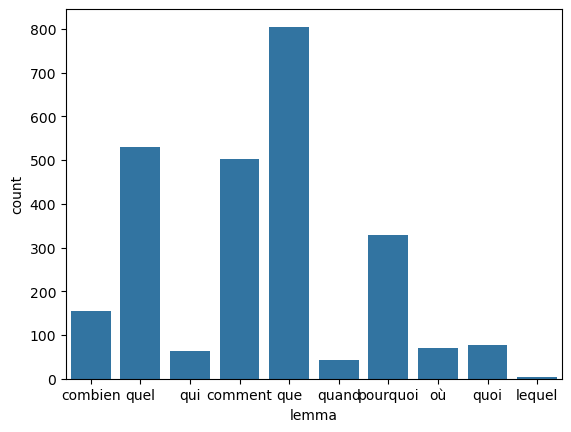

In [18]:
#Visualisation
sns.countplot(iwdf, x='lemma')

<Axes: xlabel='lemma', ylabel='mentioned'>

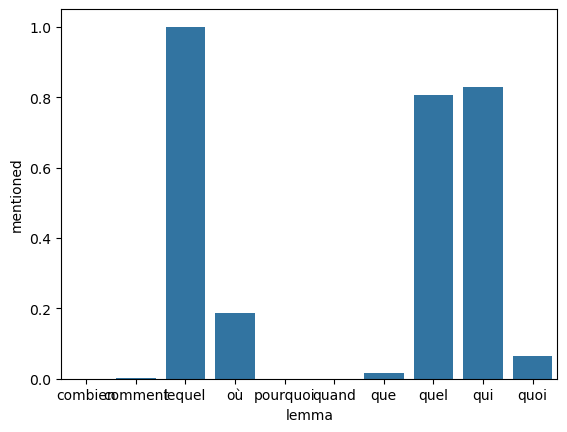

In [19]:
sns.barplot(iwdf[['lemma', 'mentioned']].groupby('lemma', as_index=False).agg('mean'), x='lemma', y='mentioned')

In [ ]:
# Detected interrogative occurrences
iwdf[['lemma', 'mentioned']][~iwdf['mentioned']].groupby('lemma', as_index=False).agg('count')

,lemma,mentioned
0,combien,155
1,comment,502
2,où,57
3,pourquoi,329
4,quand,43
5,que,791
6,quel,103
7,qui,11
8,quoi,72


In [21]:
# Same, but for interrogative mentions in chains
col_fileid = []
col_mentid = []
col_lemma = []
col_inchain = []
for fileid in fileid2corpus.keys():
    for mentid in fileid2intmentids[fileid]:
        words = [wordid2word[fileid][wordid] for wordid in mentid2wordids[fileid][mentid]]
        # Identifying the interrogative word in the mention
        target = int_word_in_mention(mentid, fileid)
        if target == "": # skipping wrong interrogative mentions
            continue
            
        lemma = lemmatize(target)
        col_fileid.append(fileid)
        col_mentid.append(mentid)
        col_lemma.append(lemma)
        col_inchain.append(mentid not in fileid2notinchain[fileid])

imdf = pd.DataFrame({'fileid': col_fileid, 'mentid':col_mentid, 'lemma':col_lemma,
                     'inchain':col_inchain})
imdf.head()

,fileid,mentid,lemma,inchain
0,CO2_ESLO_002_C,u-MENTION-aboyer_1295380490690,quel,True
1,CO2_ESLO_002_C,u-MENTION-aboyer_1295380578534,qui,False
2,CO2_ESLO_002_C,u-MENTION-jmuzerelle_1300740713340,quel,True
3,CO2_ESLO_002_C,u-MENTION-jmuzerelle_1300739009468,quel,False
4,CO2_ESLO_002_C,u-MENTION-jmuzerelle_1300741204698,quel,True


<Axes: xlabel='lemma', ylabel='count'>

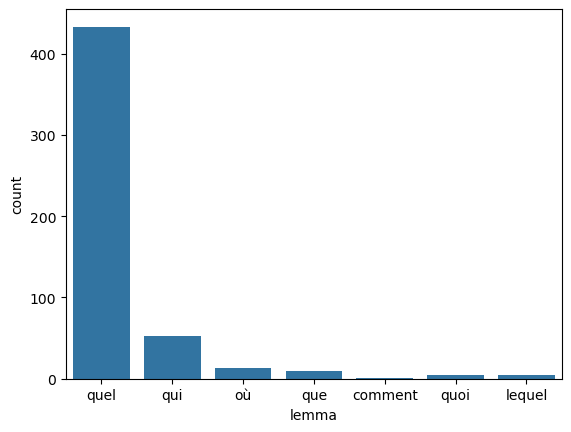

In [22]:
sns.countplot(imdf, x='lemma')

<Axes: xlabel='lemma', ylabel='inchain'>

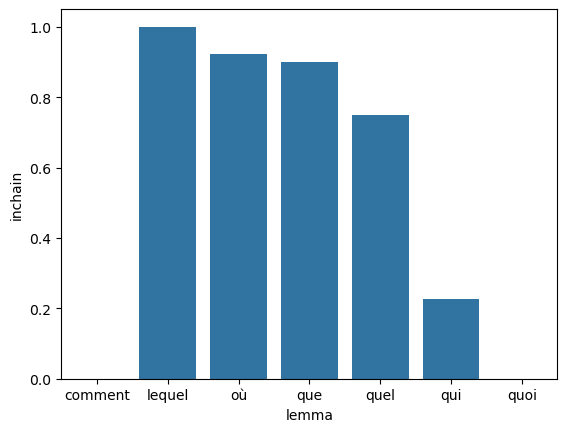

In [23]:
sns.barplot(imdf[['lemma', 'inchain']].groupby('lemma', as_index=False).agg('mean'), x='lemma', y='inchain')

In [24]:
# Interrogative mentions not in any chain or in trivial chains
imdf[['lemma', 'inchain']][~imdf['inchain']].groupby('lemma', as_index=False).agg('count')

,lemma,inchain
0,comment,1
1,où,1
2,que,1
3,quel,108
4,qui,41
5,quoi,5


In [25]:
# Interrogative mentions in non-trivial chains
imdf[['lemma', 'inchain']][imdf['inchain']].groupby('lemma', as_index=False).agg('count')

,lemma,inchain
0,lequel,4
1,où,12
2,que,9
3,quel,325
4,qui,12


## Printing files and gloss for potentially missed interrogative chains

In [26]:
lemma_of_interest = ["où", "qui", "quoi", "quel"] # too many occurrences of "que" not in a mention

# Printing sentences of interrogative words not mentioned, and a large context
def generate_notmentioned():
    with open("notmentioned.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(['fileid', 'wordid', 'lemma', 'fp', 'wh_context', 'chain', 'comment']) # fp = false positive: actual pos / reason, chain: actual chain type
        for fileid in fileid2corpus.keys():
            notmentioned_wordids = [wordid for wordid in fileid2notmentioned[fileid]
                                    if lemmatize(wordid2word[fileid][wordid]) in lemma_of_interest]
            if len(notmentioned_wordids) != 0:
                # Writing the sentences containing the occurrences with no mention
                with open(notmentioned_dir + '/' + fileid + '.md', "w") as file:
                    file.write(sentence_strings(notmentioned_wordids, fileid, context_radius=10, expand=True))
                for wordid in notmentioned_wordids:
                    writer.writerow([fileid, wordid, lemmatize(wordid2word[fileid][wordid])])

In [27]:
# Printing sentences of interrogative mentioned not in a chain, and a large context
def generate_notinchain():
    with open("notinchain.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(['fileid', 'mentid', 'lemma', 'fp', 'wh_context', 'chain', 'comment']) # fp = false positive: actual pos / reason, chain: actual chain type
        for fileid in fileid2corpus.keys():
            notinchain_mentids = [mentid for mentid in fileid2notinchain[fileid]]
            if len(notinchain_mentids) != 0:
                # Writing the sentences containing the occurrences with no mention
                with open(notinchain_dir + '/' + fileid + '.md', "w") as file:
                    file.write(chain_strings(notinchain_mentids, fileid, context_radius=10, expand=True))
                for mentid in notinchain_mentids:
                    writer.writerow([fileid, mentid, lemmatize(int_word_in_mention(mentid, fileid))])


In [28]:
# Printing sentences of interrogative mentioned in a chain, and a large context
lemma_of_interest = ["lequel", "où", "que", "qui"]

def generate_inchain():
    with open("inchain.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(['fileid', 'mentid', 'lemma', 'fp', 'wh_context', 'chain', 'comment']) # fp = false positive: actual pos / reason, chain: actual chain type
        for fileid in fileid2corpus.keys():
            inchain_mentids = [mentid for mentid in fileid2intmentids[fileid]
                               if mentid not in fileid2notinchain[fileid]]
            if len(inchain_mentids) != 0:
                # Writing the sentences containing the occurrences with no mention
                with open(inchain_dir + '/' + fileid + '.md', "w") as file:
                    file.write(chain_strings(inchain_mentids, fileid, context_radius=10, expand=True))
                for mentid in inchain_mentids:
                    writer.writerow([fileid, mentid, lemmatize(int_word_in_mention(mentid, fileid))])



##  Analysing the annotated data

In [29]:
nmdf = pd.read_csv('notmentioned.csv').fillna({'chain':'','comment':''})
nmdf = nmdf[nmdf['fp'].isna()]
nmdf['chain'] = nmdf['chain'].apply(lambda row: row.split(';'))
nmdf['comment'] = nmdf['comment'].apply(lambda row: row.split(';'))

nicdf = pd.read_csv('notinchain.csv').fillna({'chain':'','comment':''})
nicdf = nicdf[nicdf['fp'].isna()]
nicdf['chain'] = nicdf['chain'].apply(lambda row: row.split(';'))
nicdf['comment'] = nicdf['comment'].apply(lambda row: row.split(';'))

icdf = pd.read_csv('inchain_noquel.csv').fillna({'chain':'','comment':''})
icdf = icdf[icdf['fp'].isna()]
icdf['chain'] = icdf['chain'].apply(lambda row: row.split(';'))
icdf['comment'] = icdf['comment'].apply(lambda row: row.split(';'))

icdf.head()

,fileid,mentid,lemma,fp,wh_context,actual,chain,comment
3,005_C-2,u-MENTION-jmuzerelle_1358872789946,qui,NaN,q,domain,[0],[notnew]
5,006_C-3,u-MENTION-jmuzerelle_1353488186604,qui,NaN,q,rhet,[0],[notnew]
6,007_C-3,u-MENTION-gpascault_1359222055710,lequel,NaN,q,domain,[sta],[]
7,008_C-3,u-MENTION-jmuzerelle_1366030962320,lequel,NaN,q,domain,[sta],[]
19,021_C-5,u-MENTION-jmuzerelle_1356104131584,lequel,NaN,q,sta;spec:dem;cest,[/],[]


In [30]:
# Actual mentions in a chain
icdf[['lemma', 'wh_context']].groupby('lemma', as_index=False).agg('count')
# no occurrence of other interrogative words (except *quel*)

,lemma,wh_context
0,lequel,4
1,qui,5


In [31]:
# Actual mentions not in a chain
nicdf[['lemma', 'wh_context']].groupby('lemma', as_index=False).agg('count')

,lemma,wh_context
0,quel,101
1,qui,39
2,quoi,5


In [32]:
# Actual interrogative words not mentioned, only for où, qui, quoi and quel (*que* not annotated)
nmdf[['lemma', 'wh_context']].groupby('lemma', as_index=False).agg('count')
# ignored : combien, comment, pourquoi, quand

,lemma,wh_context
0,où,40
1,quel,98
2,qui,9
3,quoi,38


### Only counting the occurrences with a non-propositional referring expression

In [ ]:
# Missing mentions in notinchain
nicdf['ref'] = nicdf['chain'].apply(lambda c: '0' not in c and ''.join(list(c)) != '') # with at least one referring expression
nicdf['prop'] = nicdf['comment'].apply(lambda c: 'prop' in c) # column: whether there is at least one propositional referring expression
nicdf[nicdf['ref'] & ~nicdf['prop']][['lemma', 'wh_context']].groupby('lemma', as_index=False).agg('count')

,lemma,wh_context
0,quel,38
1,qui,36
2,quoi,3


In [ ]:
# Missing wordids in notmentioned
nmdf['ref'] = nmdf['chain'].apply(lambda c: '0' not in c and ''.join(list(c)) != '') # with at least one referring expression
nmdf['prop'] = nmdf['comment'].apply(lambda c: 'prop' in c) # column: whether there is at least one propositional referring expression
nmdf[nmdf['ref'] & ~nmdf['prop']][['lemma', 'wh_context']].groupby('lemma', as_index=False).agg('count')

,lemma,wh_context
0,où,30
1,quel,51
2,qui,7
3,quoi,21
